# Klasyfikacja hierarchiczna

## Dane hierarchiczne

Znaczna liczba problemów klasyfikacyjnych dotyczy danych o płaskiej strukturze klas. Przykładem takiej płaskiej klasyfikacji może być przypisanie wiadomości email etykiety spam/nie spam lub przypisanie obrazom ze zbioru MNIST jednej z dziesięciu etykiet reprezentujących cyfry. 

Dla niektórych problemów naturalna jest jednak hierarchiczna struktura klas przybierająca formę drzewa lub skierowanego grafu acyklicznego (DAG).

![muzyka](data/hierarchical_classification/muzyka.svg)

Przykłady problemów klasyfikacji hierarchicznej:
- klasyfikacja gatunków muzyki
- przypisanie kategorii artykułom prasowym
- klasyfikacja taksonomiczna np. obrazów medycznych

W każdym z powyższych problemów możemy zdefiniować drzewo hierarchii klas, gdzie wychodząc od korzenia będziemy mieli węzły reprezentujące najbardziej ogólne etykiety (np. dla muzyki: Rock, Klasyczna, Jazz), a w węzłach będących liśćmi będziemy mieli najbardziej szczegółowe klasy (np. soft rock, hard rock, pianino, chór, orkiestra). W tego typu problemach oprócz przewidzenia klas liści równie ważne może być przewidzenie prawidłowych etykiet na każdym poziomie hierarchii.

W niniejszym tutorialu będziemy pracowali z hierarchicznym zbiorem danych zawierającym obrazy medyczne [imclef07d](https://sites.google.com/site/hrsvmproject/datasets-hier).

## Wczytanie danych

Zbiór składa się z 3 plików:
- `imclef07d_train` - zbiór treningowy
- `imclef07d_test` - zbiór testowy
- `imclef07d.hf` - hierarchia klas w postaci listy krawędzi

Hierarchia zawiera 3 poziomy, a każdy obraz ma przypisane 3 etykiety (jedna dla każdego poziomu).

In [1]:
import re
import pandas as pd

def readDataset(path):
    with open(path, 'r', newline='\n') as file:
        column_names = list(map(( lambda x: 'F' + str(x)), range(80)))
        column_names.append('label')
        df = pd.DataFrame(columns=column_names)
        lines = file.readlines()
        for line in lines:
            line = re.split(" \d{1,2}:", line)
            labels = line[0].split(',')
            features = list(map(float, line[1:]))
            features.append([labels])
            newRow = pd.DataFrame(dict(zip(column_names, features)))
            df = pd.concat([df, newRow], ignore_index = True)
        return(df)
            
df = readDataset('data/hierarchical_classification/imclef07d_train')

Każdy obraz opisany jest zestawem osiemdziesięciu cech.

In [2]:
df

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F71,F72,F73,F74,F75,F76,F77,F78,F79,label
0,0.596529,-0.284171,0.254657,-0.162900,-0.007383,0.009371,-0.024586,-0.132000,-0.487257,-0.021700,...,0.210829,0.523171,0.275814,0.708057,0.174729,0.007300,0.440557,-0.407543,0.166243,"[15, D, 2B]"
1,0.025100,0.001543,0.397514,0.122814,-0.007383,-0.133486,0.403986,0.010857,0.084171,0.144967,...,0.353686,0.380314,0.275814,0.422343,0.317586,-0.135557,0.154843,0.592457,0.166243,"[15, D, 2B]"
2,-0.260614,0.001543,0.540371,0.408529,-0.007383,0.009371,0.118271,0.010857,0.084171,0.144967,...,0.210829,0.237457,0.418671,0.422343,0.174729,0.007300,0.583414,0.306743,0.023386,"[15, D, 2B]"
3,-0.403471,-0.284171,0.111800,-0.162900,0.159283,-0.133486,-0.024586,-0.132000,0.227029,-0.188367,...,0.210829,0.237457,-0.295614,-0.149086,-0.396700,0.007300,0.726271,-0.121829,0.023386,"[15, D, 2B]"
4,0.167957,-0.141314,0.254657,0.122814,-0.007383,-0.419200,0.118271,-0.560571,-0.344400,-0.188367,...,-0.074886,0.380314,0.418671,-0.006229,-0.539557,-0.135557,0.011986,-0.264686,-0.119471,"[15, D, 2B]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.453671,-0.284171,0.254657,0.694243,-0.007383,-0.133486,-0.310300,-0.560571,0.512743,-0.188367,...,-0.217743,-0.191114,-0.438471,-0.149086,-0.539557,-0.135557,-0.273729,-0.407543,-0.119471,"[10, 11, 20]"
9996,0.453671,-0.284171,-0.031057,-0.162900,-0.174050,-0.419200,-0.310300,-0.560571,-0.487257,-0.188367,...,0.639400,-0.333971,-0.438471,-0.149086,-0.253843,0.721586,-0.130871,-0.407543,-0.119471,"[10, 11, 20]"
9997,-0.117757,0.144400,0.111800,0.694243,0.159283,-0.419200,-0.310300,-0.560571,0.369886,-0.188367,...,-0.217743,-0.333971,-0.438471,-0.149086,-0.539557,-0.135557,-0.273729,-0.407543,-0.119471,"[10, 11, 20]"
9998,0.453671,-0.141314,0.254657,0.408529,-0.007383,-0.419200,-0.167443,-0.560571,-0.487257,-0.188367,...,-0.217743,-0.333971,-0.438471,-0.149086,-0.110986,-0.135557,-0.273729,-0.407543,-0.119471,"[10, 11, 20]"


Wizualizacja struktury klas

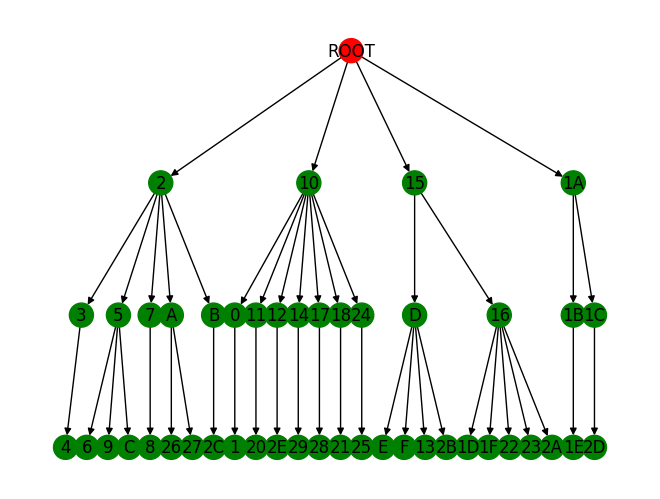

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

with open("data/hierarchical_classification/imclef07d.hf", "r", newline="\n") as file:
    G = nx.read_edgelist(file, create_using=nx.DiGraph)

G = nx.relabel_nodes(G, {'19':'ROOT'})

color_map = ['red' if node == 'ROOT' else 'green' for node in G] 
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, node_color=color_map)
plt.show()

## Podejścia do klasyfikacji hierarchicznej

### Klasyfikatory lokalne (top-down)
Jest to najczęściej wykorzystywane podejście do klasyfikacji hierarchicznej. Hierarchia jest wzięta pod uwagę poprzez wykorzystanie perspektywy lokalnej - wytrenowanie wielu lokalnych klasyfikatorów. W zależności od sposobu wykorzystania lokalnej informacji możemy wyróżnić 3 metody: LCN, LCPN i LCL.

##### **LCN** - local classifier per node

Dla każdego węzła (poza korzeniem) uczony jest binarny klasyfikator, który decyduje czy dany przykład należy, czy nie należy do danej klasy. Wadą tego podejścia jest możliwość propagacji błędu w głąb drzewa.

Klasyfikatory binarne wymagają podjęcia decyzji, które klasy będziemy traktowali jako pozytywne, a które jako negatywne. Jest to tak zwana *polityka treningu klasyfikatora binarnego*, która będzie miała wpływ na otrzymane wyniki (zobacz więcej w sekcji 4.1 [Silla et al.](https://link.springer.com/content/pdf/10.1007/s10618-010-0175-9.pdf)).

![lcn](data/hierarchical_classification/lcn.svg)


##### **LCPN** - local classifier per parent node

Dla każdego węzła-rodzica uczony jest klasyfikator, który przypisuje swoje dzieci do odpowiedniej klasy. Podobnie jak przy LCN, tutaj również błąd klasyfikacji popełniony na pewnym poziomie hierarchii będzie dalej propagowany.

![lcpn](data/hierarchical_classification/lcpn.svg)

##### **LCL** - local classifier per level

Dla każdego poziomu w drzewie hierarchii uczony jest klasyfikator decydujący, do którego węzła na danym poziomie przypisać dany przykład. Stosując to podejście trzeba mieć na uwadze, że możemy otrzymać niespójność przypisanych klas (np. pierwszy poziom: 2, drugi poziom: 1.1), ale może to również uchronić nas przed propagacją błędu z poprzedniego poziomu.

![lcl](data/hierarchical_classification/lcl.svg)

### Podejście globalne (Big Bang)
W tym podejściu uczymy jeden model dla całej hierarchii, który zwykle jest mniejszy niż modele oparte na lokalnych klasyfikatorach. Przykładem takiego modelu może być HC4.5 (hierarchiczny wariant C4.5).

### Klasyfikacja płaska
Do danych hierarchicznych możemy również zastosować zwykłe klasyfikatory dla danych płaskich. Oczywistą wadą tego rozwiązania jest zignorowanie podczas uczenia informacji o hierarchii klas. Może się jednak okazać, że takie proste rozwiązanie będzie wystarczające dla rozwiązywanego problemu.

## Głębokość klasyfikacji

Kolejną decyzją jaką musimy podjąć w przypadku klasyfikacji hierarchicznej jest ustalenie głębokości klasyfikacji:
- `mandatory leaf-node prediction (MLNP)` - dla każdego przykładu przechodzimy przez całe drzewo hierarchii i przypisujemy klasę aż do poziomu liści.
- `non-mandatory leaf-node prediction (NMLP)` - możemy zdefiniować kryterium stopu i zatrzymać klasyfikację danego przykładu na węźle niebędącym liściem.

## Klasyfikacja hierarchiczna przy pomocy HiClass

[HiClass](https://hiclass.readthedocs.io/en/latest/index.html) jest biblioteką w Pythonie pozwalającą na przeprowadzenie w prosty sposób klasyfikacji hierarchicznej. Narzędzie to posiada następujące funkcjonalności:
- zaimplementowane algorytmy
    - LCN
    - LCPN
    - LCL
- obsługę hierarchii z różną liczbą poziomów
- wybór polityki treningu klasyfikatora binarnego
- hierarchiczne wersje miar:
    - hRecall
    - hPrecision
    - hF1
- kompatybilność z scikit-learn

UWAGA: aktualnie HiClass najlepiej używać z Pythonem 3.8. Dla wyższych wersji mogą pojawić się błędy.

In [5]:
from hiclass import LocalClassifierPerNode
from sklearn.ensemble import RandomForestClassifier

X_train = df.iloc[:,:-1]
Y_train = df.iloc[:,-1].tolist()

rf = RandomForestClassifier()
classifier = LocalClassifierPerNode(local_classifier=rf)
classifier.fit(X_train, Y_train)

2022-11-14 13:44:32,889 - LCPN - WARNING - Fitting ConstantClassifier for node '8'
2022-11-14 13:44:34,624 - LCPN - WARNING - Fitting ConstantClassifier for node '2C'
2022-11-14 13:44:34,989 - LCPN - WARNING - Fitting ConstantClassifier for node '4'
2022-11-14 13:44:36,090 - LCPN - WARNING - Fitting ConstantClassifier for node '2D'
2022-11-14 13:44:37,411 - LCPN - WARNING - Fitting ConstantClassifier for node '2E'
2022-11-14 13:44:37,553 - LCPN - WARNING - Fitting ConstantClassifier for node '29'
2022-11-14 13:44:37,682 - LCPN - WARNING - Fitting ConstantClassifier for node '25'
2022-11-14 13:44:37,823 - LCPN - WARNING - Fitting ConstantClassifier for node '1'
2022-11-14 13:44:37,972 - LCPN - WARNING - Fitting ConstantClassifier for node '28'
2022-11-14 13:44:38,096 - LCPN - WARNING - Fitting ConstantClassifier for node '21'
2022-11-14 13:44:38,908 - LCPN - WARNING - Fitting ConstantClassifier for node '1E'
2022-11-14 13:44:39,038 - LCPN - WARNING - Fitting ConstantClassifier for node 

LocalClassifierPerNode(local_classifier=RandomForestClassifier())

## Ewaluacja

Ewaluacja klasyfikacji hierarchicznej nie jest prostym zadaniem, ponieważ nie istnieje jedna uniwersalna miara, która będzie w stanie uchwycić hierarchiczny charakter danych, a dodatkowo uwzględni różne specyficzne wymagania rozwiązywanego problemu.

Dobrze znane miary takie jak precision, recall czy F1 nie pokażą nam jak dobrze nasz model odwzorowuje hierarchię danych. Mimo tego ograniczenia miary te są często stosowane.

 W literaturze zostały zaproponowane hierarchiczne odpowiedniki wyżej wspomnianych miar:
 
 - $hRecall = \frac{\sum_i|T_i \cap P_i|}{\sum_i|T_i|}$

 - $hPrecision = \frac{\sum_i|T_i \cap P_i|}{\sum_i|P_i|}$

 - $hF1 = \frac{2 \times hRecall \times hPrecision}{hRecall + hPrecision}$

gdzie $P_i$ to przewidziane kolejne etykiety w hierarchii dla przykładu $i$, a $T_i$ to prawdziwe etykiety przykładu $i$.

Czasami może się okazać, że również hierarchiczne miary nie są w stanie uchwycić tego, co jest poprawną, a co błędną klasyfikacją w kontekście hierarchii. W takich przypadkach może być potrzebne zdefiniowanie własnej miary uwzględniającej specyfikę danej dziedziny i problemu.

In [6]:
from hiclass import metrics

df = readDataset('data/hierarchical_classification/imclef07d_test')

X_test = df.iloc[:,:-1]
Y_test = df.iloc[:,-1]
predictions = classifier.predict(X_test)

hR = metrics.recall(Y_test.tolist(), predictions)
hP = metrics.precision(Y_test.tolist(), predictions)
hF1 = metrics.f1(Y_test.tolist(), predictions)

print("hRecall = ", hR, "\nhPrecision = ", hP, "\nhF1 = ", hF1)

hRecall =  0.7982107355864811 
hPrecision =  0.7982107355864811 
hF1 =  0.7982107355864811


## Rekomendowana literatura

[Silla, Carlos N., and Alex A. Freitas. "A survey of hierarchical classification across different application domains." Data Mining and Knowledge Discovery 22.1 (2011): 31-72.](https://link.springer.com/content/pdf/10.1007/s10618-010-0175-9.pdf)